In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_percentage_error
from deap import base, creator, tools, algorithms

In [2]:
SEED = 42
np.random.seed(SEED)

data = pd.read_csv('DATA_KOTA.csv')

df = pd.DataFrame(data)

# Normalisasi MinMax
scaler = MinMaxScaler()
df['jumlah_kecelakaan'] = scaler.fit_transform(df[['jumlah_kecelakaan']])

# Menambahkan kolom lag (pergeseran)
df['jumlah_kecelakaan_lag'] = df['jumlah_kecelakaan'].shift(1)
df = df.dropna() # Menghapus baris dengan nilai NaN

In [3]:
# Memisahkan data latih dan data uji sesuai rasio (0.8 untuk 80:20)
train_size = int(0.8 * len(df))
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

# Memisahkan fitur dan target untuk data latih
X_train = train_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_train = train_data['jumlah_kecelakaan'].values

# Memisahkan fitur dan target untuk data uji
X_test = test_data['jumlah_kecelakaan_lag'].values.reshape(-1, 1)
y_test = test_data['jumlah_kecelakaan'].values

In [4]:
# Define evaluation function
def evaluate(individual):
    C, epsilon = individual
    if C <= 0 or epsilon <= 0:
        return float('inf'),
    svr = SVR(kernel='linear', C=C, epsilon=epsilon)
    svr.fit(X_train, y_train)
    y_pred = svr.predict(X_test)
    mape = mean_absolute_percentage_error(y_test, y_pred) * 100
    return mape,
    
# Setup DEAP framework
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Parameter ranges
parameter_ranges = [(0.0001, 50), (1e-07, 5)]

# Register genetic operators
toolbox.register("attr_float", random.uniform)
toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (lambda: random.uniform(*parameter_ranges[0]),
                  lambda: random.uniform(*parameter_ranges[1])), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", tools.cxUniform, indpb=0.1)  # Menggunakan crossover uniform
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)  # Menggunakan mutasi flipbit
toolbox.register("select", tools.selTournament, tournsize=3) # Menggunakan seleksi turnamen
toolbox.register("evaluate", evaluate)

MAPE terbaik untuk populasi 25: 29.62640704595026
MAPE terbaik untuk populasi 50: 31.3139119219494
MAPE terbaik untuk populasi 75: 31.809999466182816
MAPE terbaik untuk populasi 100: 31.41910376975008
MAPE terbaik untuk populasi 125: 29.330640740491976
MAPE terbaik untuk populasi 150: 29.832254379807292
MAPE terbaik untuk populasi 175: 29.54618620090151
MAPE terbaik untuk populasi 200: 29.704513642843462
MAPE terbaik untuk populasi 225: 31.774473521423914
MAPE terbaik untuk populasi 250: 29.3083316428085
MAPE terbaik untuk populasi 500: 28.95465191124816
MAPE terbaik untuk populasi 1000: 29.915540138065715

Ukuran populasi optimal: 500
MAPE terbaik: 28.95465191124816


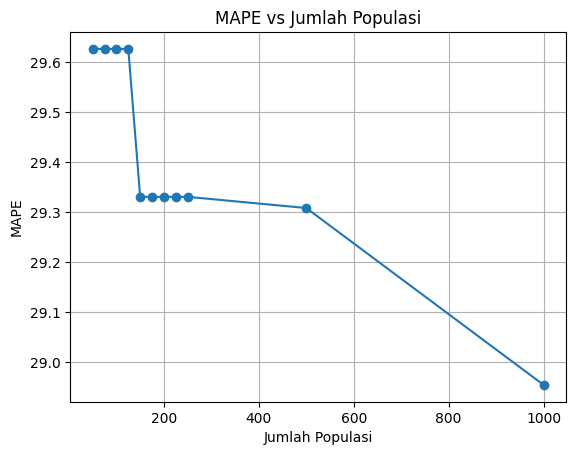

In [5]:
def main():
    population_size = 80
    num_generations_list = [25, 50, 75, 100, 125, 150, 175, 200, 225, 250, 500, 1000]
    crossover_rate = 0.5
    mutation_rate = 0.2
    
    best_num_generations = None
    best_mape = float('inf')
    
    results = []

    for num_generations in num_generations_list:
        population = toolbox.population(n=population_size)

        for generation in range(num_generations):
            offspring = algorithms.varAnd(population, toolbox, cxpb=crossover_rate, mutpb=mutation_rate)
            fits = toolbox.map(toolbox.evaluate, offspring)
            for fit, ind in zip(fits, offspring):
                ind.fitness.values = fit

            population = toolbox.select(offspring, k=len(population))

        best_individual = tools.selBest(population, k=1)[0]
        mape = best_individual.fitness.values[0]

        results.append((num_generations, best_mape))
        print(f"MAPE terbaik untuk populasi {num_generations}: {mape}")

        if mape < best_mape:
            best_mape = mape
            best_num_generations = num_generations

    print(f"\nUkuran populasi optimal: {best_num_generations}")
    print(f"MAPE terbaik: {best_mape}")

    # Plot hasil setiap iterasi dan nilai MAPE-nya
    num_generations, best_num_generations_mape = zip(*results)
    plt.plot(num_generations, best_num_generations_mape, marker='o')
    plt.xlabel("Jumlah Populasi")
    plt.ylabel("MAPE")
    plt.title("MAPE vs Jumlah Populasi")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()